# Scaling TTI equations from Fletcher et al

In [81]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

In [98]:
# setting up a grid 
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# creating functions for the two pressure fields
p = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# defining constants and calculating velocities
sigma = 0.1
epsilon = 0.24
theta = sp.pi/4
alpha = 1
vpz = 3
vpx = 3*np.sqrt(1+2*epsilon)
vpn = 3*np.sqrt(1+2*sigma)
vsz = 0


# defining derivative operator functions
def h1(function, theta):
    operator = sp.sin(theta)**2*function.dx2 + sp.cos(theta)**2*function.dz2 + sp.sin(2*theta)*function.dx.dz
    return operator

def h2(function, theta):
    operator = function.laplace - h1(function, theta)
    return operator

# defining equations
eq_p = p.dt2 - vpx**2*h2(p, theta) - alpha*vpz**2*h1(q, theta) - vsz**2*(h1(p, theta) - alpha*h1(q, theta))
eq_q = q.dt2 - (vpn**2/alpha)*h2(p, theta) - vpz**2*h1(q, theta) + vsz**2*((1/alpha)*h2(p, theta) - h2(q, theta))

# define dt using the cfl condition
vmax = vpx
dt = np.amin(grid.spacing)*0.6/vmax

# define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)
src_q = src.inject(field=q.forward, expr=src)

# defining stencils
stencil_p = dv.Eq(p.forward, dv.solve(eq_p, p.forward))
stencil_q = dv.Eq(q.forward, dv.solve(eq_q, q.forward))

# set up operator
op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
op(dt=dt)


Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.08122099999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

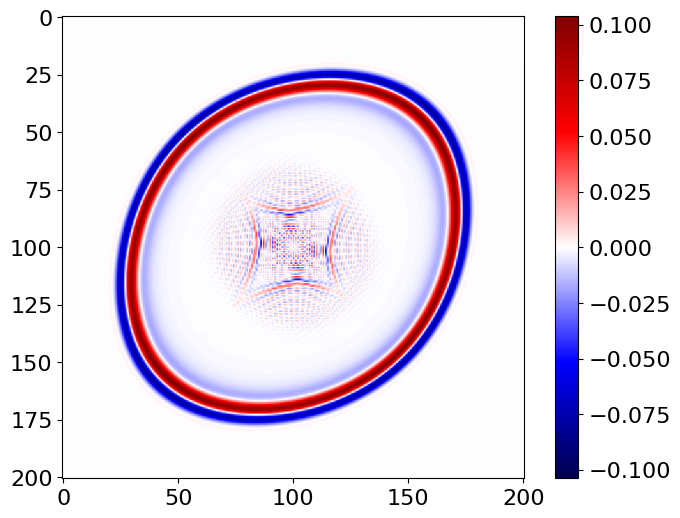

In [99]:
vmax = np.amax(np.abs(p.data[0]))
plt.imshow(p.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()